In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image, ImageOps
import os
import json
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import torch.optim as optim

import cv2

import random
import numpy as np
    
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/DPA_23.2_OnePose_v1.0.1.1")

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [13]:
# Dataset do složky DataSet -- Dataset1
#                           |- Dataset2

# Rozdělit Dataset na 2-3 Train, Test, Validation
# Validation je až poslední
# shuffle data
# balance data nemít 40% stejnou ground truth (tohle je asi u classifierů)

#### DEFINE DataLoader ####


class data(Dataset):
    def __init__(self, path):
        self.path = path
        self.Items = []

        convert_tensor = transforms.ToTensor()
        convert_float = transforms.ConvertImageDtype(torch.float)

        self.files = os.listdir(path)

        for ML_Record in self.files:
            DatasetItem = json.load(open(os.path.join(self.path, ML_Record)))
            for i in range(0, 200):

                src = cv2.imread(DatasetItem["src"], cv2.IMREAD_GRAYSCALE)
                dst = cv2.imread(DatasetItem["dst"], cv2.IMREAD_GRAYSCALE)
                originalTransfrom = np.matrix(DatasetItem["transformation"])

                translationX = random.uniform(80, 150) * random.choice([1, -1])
                translationY = random.uniform(80, 120) * random.choice([1, -1])
                scale = random.uniform(0.8, 1.2)
                rotation = random.uniform(5, 15) * random.choice([1, -1])

                AugmentingMat = np.mat([[scale, 0., translationX], [0., scale, translationY], [0., 0., 1.]] , dtype=np.float32)
                rotationMat = cv2.getRotationMatrix2D( (src.shape[1]//2, src.shape[0]//2), rotation, 1)
                AugmentingMat = np.matmul( np.vstack([rotationMat, [0,0,1]]), AugmentingMat,dtype=np.float32)

                invertedAugmentingMat = np.mat(cv2.invertAffineTransform(AugmentingMat[0:-1, : ]))
                invertedAugmentingMat = np.vstack([invertedAugmentingMat, [0,0,1]])

                GeneratedTransform = np.matmul(originalTransfrom, invertedAugmentingMat)

                points = [ [0, 0, 1], [1440, 1440, 1], [0, 1440, 1], ]
                warpedPoints = np.matmul(points, GeneratedTransform.transpose(),  dtype=np.float32)

                warped = cv2.warpAffine(src, AugmentingMat[0:-1, : ], (1440, 1440))

                warped = cv2.resize(warped, (128, 128))
                dst = cv2.resize(dst, (128, 128))

                stacked = torch.stack((convert_tensor(dst), convert_tensor(warped)))
                paths = {
                    "src" : DatasetItem["src"],
                    "dst" : DatasetItem["dst"]
                }
                self.Items.append( (stacked, torch.from_numpy(warpedPoints[:, 0:-1].flatten()), paths ))

    # the function returns length of data
    def __len__(self):
        return len(self.Items)

    # gives one item at a time
    def __getitem__(self, index):
        return self.Items[index]


In [14]:
#### DEFINE Neural Network ####
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self._to_linear = None

        # 2 input image channel, 64 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.fc9 = nn.Linear(16384, 1024)

        self.fc10 = nn.Linear(1024, 6)

    def convs(self, x):
        # max pooling over 2x2
        # two conv layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
            
        return x

    def forward(self, x):

        x = self.convs(x)
        x = x.view(-1, x[0].shape[0] * x[0].shape[1] * x[0].shape[2])

        # two linear layers
        x = F.relu(self.fc9(x))
        x = self.fc10(x)
        
        return x


In [15]:
#### Create data ####

Dataset = data('.\\..\\data03\MachineData')
train_set, val_set = torch.utils.data.random_split(Dataset, [int(Dataset.__len__() * 0.8), Dataset.__len__() - int(Dataset.__len__() * 0.8)])
train_dataloader = DataLoader(train_set, batch_size=25, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=1, shuffle=True)

net = Net().to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0)

example_images, example_groundTruths, _ = iter(train_dataloader).next()
writer.add_graph(net, example_images.to(device).view(-1, 2, 128, 128))

Epochs = 12
train_set_len = len(train_set)  
# Learning
for epoch in range(Epochs):
    running_loss = 0.0
    epoch_loss = 0.0
    batchCount = 0
    for i, dataBatch in enumerate(train_dataloader):
        Images, groundTruths, _ = dataBatch
        Images, groundTruths = Images.to(device), groundTruths.to(device)

        optimizer.zero_grad()

        outputs = net(Images.view(-1, 2, 128, 128)) 

        loss = loss_function(outputs, groundTruths.view(-1,6))
        loss.backward() 
        optimizer.step() 

        running_loss += loss.item()
        epoch_loss += loss.item()
        batchCount += 1

        if((i+1)%2 == 0):
            writer.add_scalar('training loss', running_loss / 2, (train_set_len * epoch) + (i * 25) )
            running_loss = 0.0

    # Training
    print(f"Epoch: {epoch}. Loss: {epoch_loss / batchCount}")

Epoch: 0. Loss: 374941.793070211
Epoch: 1. Loss: 69789.21261160714
Epoch: 2. Loss: 63156.44642857143
Epoch: 3. Loss: 57029.7481737013
Epoch: 4. Loss: 51956.60191761364
Epoch: 5. Loss: 44073.480747767855
Epoch: 6. Loss: 40091.47874391234
Epoch: 7. Loss: 37126.75225750812
Epoch: 8. Loss: 37790.36556412338
Epoch: 9. Loss: 30767.592963676947
Epoch: 10. Loss: 29946.87294541396
Epoch: 11. Loss: 24099.642375202922


In [16]:
iterations = []
imageCounter = 0
with torch.no_grad():
        for dataBatch in val_dataloader:
                Images, groundTruths, paths = dataBatch
                Images, groundTruths = Images.to(device), groundTruths.to(device)
                outputs = net(Images.view(-1, 2, 128, 128)) 

                # writing on disk for demo
                # srcPath = paths["src"][0]
                # dstPath = paths["dst"][0]
                # src = cv2.imread(srcPath, cv2.IMREAD_ANYCOLOR)
                # dst = cv2.imread(dstPath, cv2.IMREAD_ANYCOLOR)    
                outputPoints = np.array(outputs[0].view(3,2).cpu()) 
                srcPoints = np.array([ [0, 0], [1440, 1440], [0, 1440], ]).astype(np.float32)
                outputTransform = cv2.getAffineTransform(srcPoints, outputPoints)

                src = Images[0][1]
                src = src.cpu().detach().numpy()
                src = cv2.resize(src[0], (1440, 1440))
                warped = cv2.warpAffine(src, outputTransform, (src.shape[1], src.shape[0]))

                grayImage = np.array(warped * 255, dtype = np.uint8)
                cv2.imwrite(f".\\..\\CNNAlignedImages\\Image{imageCounter}.png", grayImage)
                imageCounter += 1


                loss = loss_function(outputs, groundTruths.view(-1,6))
                iterations.append({ "batch": dataBatch, "outputs":outputs, "loss": loss})

loss: 4296.34326171875


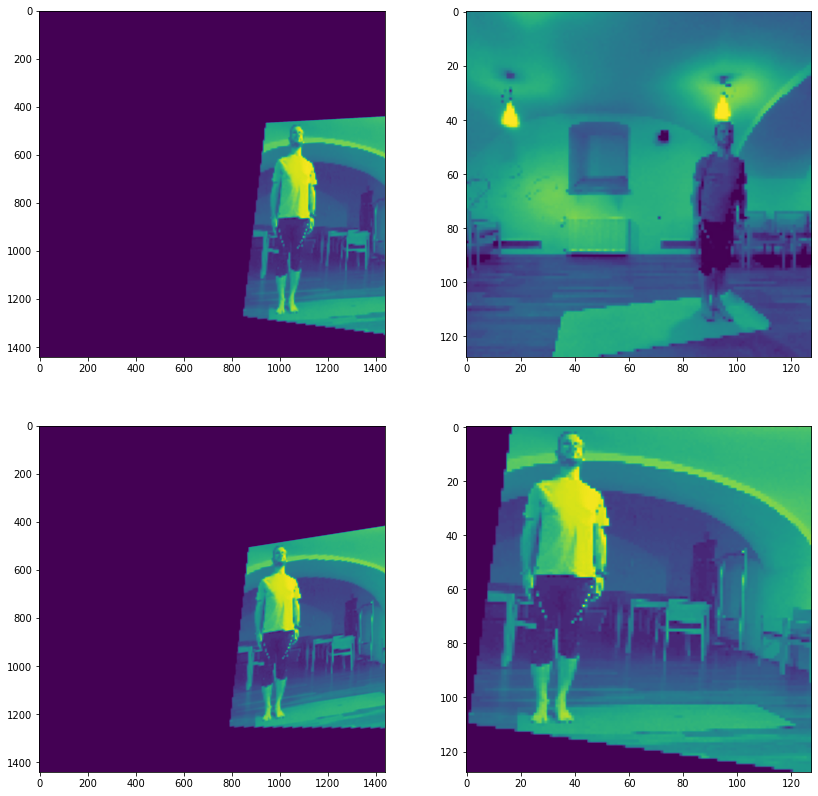

In [19]:
iteration = random.choice(iterations)
im, gt, paths = iteration["batch"]

np.set_printoptions(precision=3, suppress=True)

# print(f"Ground Truth :\n {np.array(gt[0].view(3,2))}")
# print(f"Transofrm    :\n {np.array(iteration['outputs'][0].view(3,2))}")
print(f"loss: {iteration['loss']}")

src = im[0][1]
src = src.cpu().detach().numpy()
src = cv2.resize(src[0], (1440, 1440))

dst = im[0][0]
dst = dst.cpu().detach().numpy()
dst = cv2.resize(dst[0], (1440, 1440))

groundPoints = np.array(gt.view(3,2))
outputPoints = np.array(iteration['outputs'][0].view(3,2).cpu())

srcPoints = np.array([ [0, 0], [1440, 1440], [0, 1440], ]).astype(np.float32)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Ground Truth
gtTransform = cv2.getAffineTransform(srcPoints, groundPoints)
warped = cv2.warpAffine(src, gtTransform, (1440, 1440))
axes[0][0].imshow(warped)

# Network Result
outputTransform = cv2.getAffineTransform(srcPoints, outputPoints)
warped = cv2.warpAffine(src, outputTransform, (1440, 1440))

axes[1][0].imshow(warped)

# Network Imputs
axes[0][1].imshow(im[0][0].view(128,128))
axes[1][1].imshow(im[0][1].view(128,128))

